In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


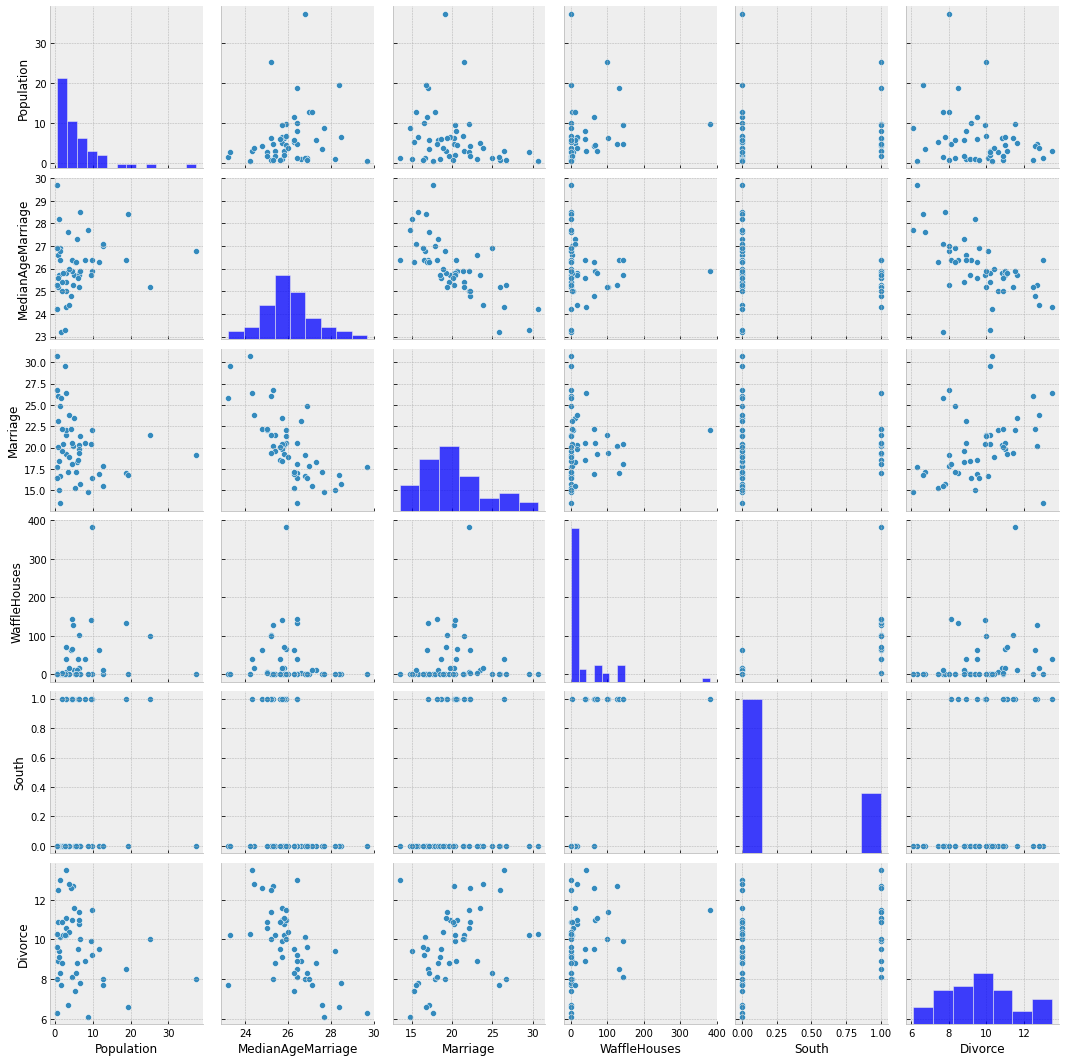

In [3]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl");

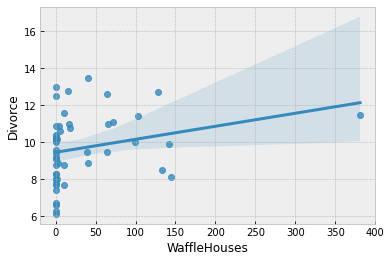

In [4]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);


In [5]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

In [6]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

In [7]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:04<00:00, 659.45it/s, 3 steps of size 7.47e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.11      0.01     -0.17      0.20   1375.91      1.00
        bM      0.35      0.13      0.35      0.13      0.57   1856.95      1.00
     sigma      0.95      0.10      0.94      0.78      1.10   1761.63      1.00

Number of divergences: 0


In [8]:
samples_1

{'a': DeviceArray([ 0.16836269,  0.11153641, -0.07910444, ...,  0.20352526,
               0.2501662 ,  0.2853731 ], dtype=float32),
 'bM': DeviceArray([0.3176959 , 0.29481456, 0.26794758, ..., 0.41887456,
              0.54202205, 0.6190211 ], dtype=float32),
 'sigma': DeviceArray([0.9858211, 0.8356587, 1.1371453, ..., 0.8968146, 1.0282842,
              1.0447978], dtype=float32)}

In [12]:
jnp.expand_dims(samples_1['a'], -1).shape

(2000, 1)

In [18]:
(jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values).shape

(2000, 50)

In [14]:
dset.MarriageScaled.values.shape

(50,)

In [10]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

In [19]:
# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
    )

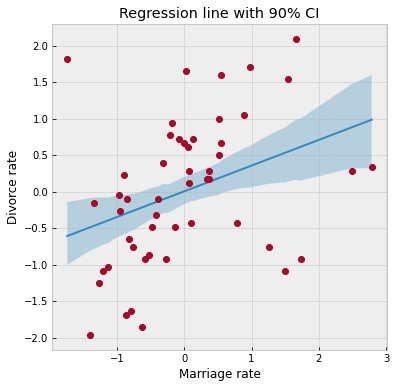

In [26]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);

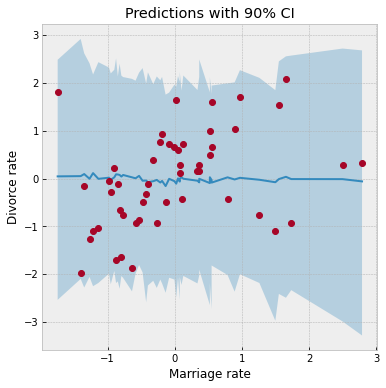

In [29]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, 
                     mean_prior_pred, 
                     hpdi_prior_pred)

ax.set(xlabel="Marriage rate", 
       ylabel="Divorce rate", 
       title="Predictions with 90% CI");

In [34]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,-0.029558
1,Alaska,0.560670
2,Arizona,0.009621
3,Arkansas,0.580923
4,California,-0.051487


In [38]:
help(handlers)

Help on module numpyro.handlers in numpyro:

NAME
    numpyro.handlers

DESCRIPTION
    This provides a small set of effect handlers in NumPyro that are modeled
    after Pyro's `poutine <http://docs.pyro.ai/en/stable/poutine.html>`_ module.
    For a tutorial on effect handlers more generally, readers are encouraged to
    read `Poutine: A Guide to Programming with Effect Handlers in Pyro
    <http://pyro.ai/examples/effect_handlers.html>`_. These simple effect handlers
    can be composed together or new ones added to enable implementation of custom
    inference utilities and algorithms.
    
    **Example**
    
    As an example, we are using :class:`~numpyro.handlers.seed`, :class:`~numpyro.handlers.trace`
    and :class:`~numpyro.handlers.substitute` handlers to define the `log_likelihood` function below.
    We first create a logistic regression model and sample from the posterior distribution over
    the regression parameters using :func:`~numpyro.infer.MCMC`. The `log_likeli

In [35]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace["obs"]["value"]

# vectorize predictions via vmap
predict_fn = vmap(
    lambda rng_key, samples: predict(
        rng_key, samples, model, marriage=dset.MarriageScaled.values
    )
)

In [36]:
# Using the same key as we used for Predictive - note that the results are identical.

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,-0.029558
1,Alaska,0.560670
2,Arizona,0.009621
3,Arkansas,0.580923
4,California,-0.051487


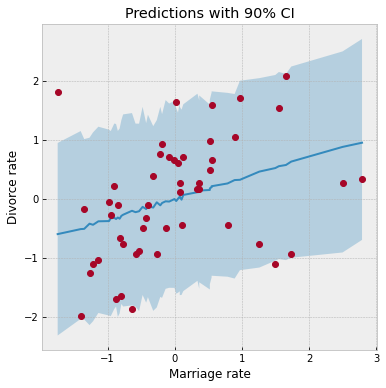

In [37]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");